# Hypothesis testing

In this notebook we will examine one of the foundational pillars of basic statistics. We will be looking at the hypothesis test. We will:

1. Look at what a hypothesis test is.

2. Perform a hypothesis test on the [R 'CO2' dataset](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/zCO2.html).

3. Perform a better hypothesis test on the same dataset.

4. Analyze the results of our hypothesis test to understand what it means.

This post will be targeted at relative beginners and I will be using certain vocabulary terms (like sample, data, distribution) interchangly here to make concepts easier to understand. This may rile some feathers: oh well.

# What is a hypothesis test?

Put simply **a hypothesis test is tool we can use to answer a question.** Here is our question: We want to know **whether or not cooling plants affects (increases or decreases) their CO2 absorbtion.** In a hypothesis test we formulate two possible outcomes (answers to our question) as 'hypotheses.' The hypothesis test looks like:

Hypothesis 1: Chilling plants does not affect their CO2 absorbtion.

Hypothesis 2: Chilling plants does affect their CO2 absorbtion.

We will call Hypothesis 1 the 'Null Hypothesis' because this is the outcome where nothing or 'null' happens. We will call Hypothesis 2 the 'Alternate Hypothesis' this is the outcome that differs from the null hypothesis: chilling plants affects their CO2 absorbtion.

The dataset we will be using is the [R 'CO2' dataset](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/zCO2.html). In this dataset the CO2 (carbon dioxide) absorbtion rate of chilled plants and the CO2 absorbtion rates of unchilled plants was measured. I have cleaned the data by removing the index, I suggest you use my [data file]() or do the same. We will take this data and use a hypothesis test to determine if the CO2 absorbtion of plants in a 'chilled' environment differs from plants in a 'non-chilled' environment.

In [1]:
# import some useful packages
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats
from fitter import Fitter
import matplotlib.pyplot as plt

# silence warnings for beautification
import warnings
warnings.filterwarnings('ignore')

In [2]:
# create a dataframe df with our data
df = pd.read_csv('co2_data.csv')
df.head()

,Plant,Type,Treatment,conc,uptake
0,Qn1,Quebec,nonchilled,95,16.0
1,Qn1,Quebec,nonchilled,175,30.4
2,Qn1,Quebec,nonchilled,250,34.8
3,Qn1,Quebec,nonchilled,350,37.2
4,Qn1,Quebec,nonchilled,500,35.3


We need to have a look quickly at the data to make sure it doesn't have any weird characteristics. Lets check that the number of chilled and nonchilled plants is the same. Below we can see they are even; if they weren't this would make it harder to do our hypothesis test.

In [3]:
# count how many chilled/unchilled plant measurements we have
nonchill_plants = df[df['Treatment'] == 'nonchilled']
chill_plants = df[df['Treatment'] == 'chilled']
num_nonchilled = nonchill_plants.shape[0]
num_chilled = chill_plants.shape[0]
print('num chilled: {}, num normal: {}'.format(num_chilled, num_nonchilled))

num chilled: 42, num normal: 42


In many instances it's better to have more data than this (42 samples) to be able to make firmly reject or accept a hypothesis, usually a sample of at least 100 is considered desirable for being able to answer hypotheses. 42 is not too low though and we can probably get away with using this many samples.

Now lets check that the number of observations is even across recording concentrations. If there are more expermiments at higher or lower concentrations of CO2 this could affect our ability to test. It looks like the number of experiments at each concentration is indeed even.

In [4]:
# check to see if there is bias
# in the concentrations of CO2
df.groupby('conc').size()

conc
95      12
175     12
250     12
350     12
500     12
675     12
1000    12
dtype: int64

Let's graph the CO2 absorbtion values for non-chilled plants. We will call this distribution our 'non-chilled' distribution.

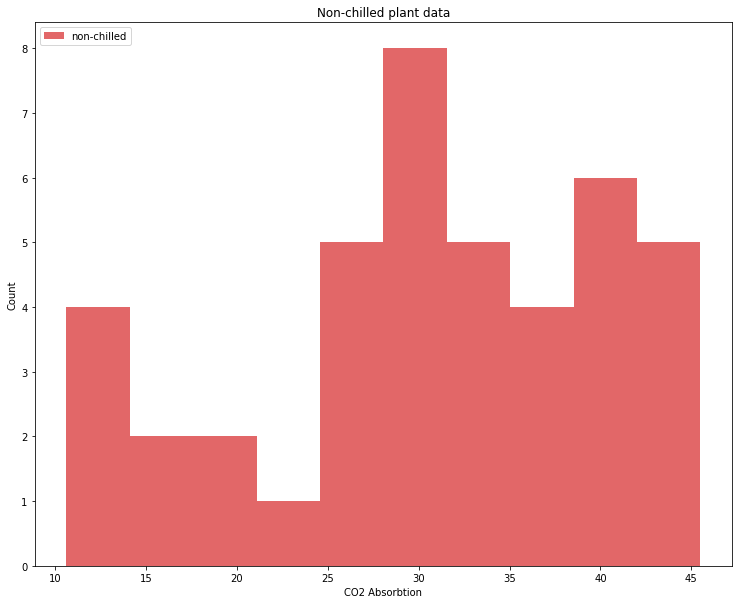

In [5]:
plt.figure(figsize=(12.5,10))
plt.hist(nonchill_plants['uptake'], color='C3', label='non-chilled', alpha=0.7)
plt.xlabel('CO2 Absorbtion')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.title('Non-chilled plant data')
plt.show()

**So we have our data:**

Our distribution of non-chilled plants has two (or three?) bumps, with most data points in the right bump.

**And we have our hypotheses:**

*Null Hypothesis*: Chilling plants does not affect their CO2 absorbtion.

*Alternate Hypothesis*: Chilling plants does affect (increase or decrease) their CO2 absorbtion.

**Now we need to find out which hypothesis occurred by looking at the data.**

One way to find out is to compare the distributions of the data with our eyes. If the chilled plant distribution differs significantly from the non-chilled distribution then the *alternate hypothesis* is probably correct. If the two distributions are the same then then *null hypothesis* is probably correct. Let's graph both distributions and compare.

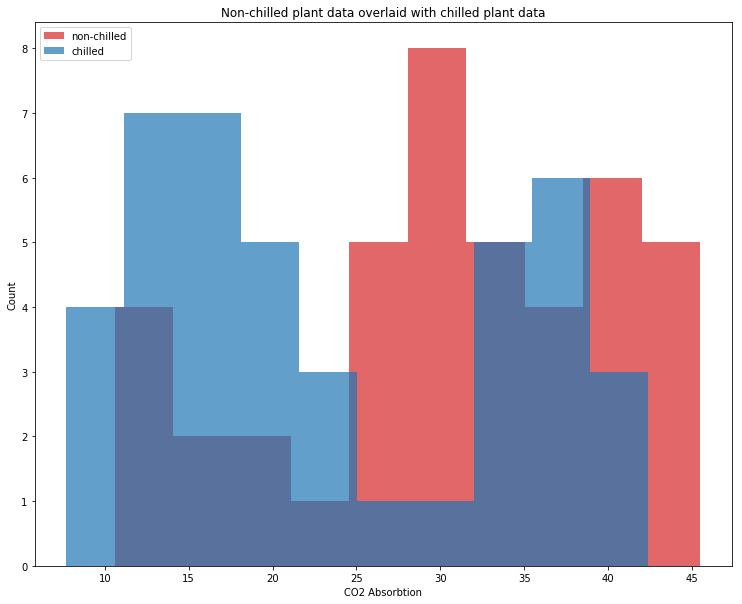

In [6]:
plt.figure(figsize=(12.5,10))
plt.hist(nonchill_plants['uptake'], label='non-chilled', color='C3', alpha=0.7)
plt.hist(chill_plants['uptake'], label='chilled', color='C0', alpha=0.7)
plt.xlabel('CO2 Absorbtion')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.title('Non-chilled plant data overlaid with chilled plant data')
plt.show()

This chilled plant distrbiution (blue) looks significantly rebalanced towards lower values of CO2 absorbtion. **This implies that the chilling of plants affects their CO2 absorbtion; we can choose our alternate hypothesis as correct:**

~~*Null Hypothesis*: Chilling plants does not affect their CO2 absorbtion.~~

*Alternate Hypothesis*: Chilling plants does affect (increase or decrease) their CO2 absorbtion.

Comparing distribtutions with your eyes is the simplest way to choose between two possible hypotheses.

# Statistical tests

While the prior method seems ot work well enough for the problem posed here it is not entirely robust. Sometimes two distributions are not easy to tell apart. How can we objectively tell when one distribution is different from another distribution?

You can use something called a **statistical test: it tells you how similar two distributions are** or more precisely it tells you the probability (p-value) that data you are testing came from a particular distribution. Below we are going to perform a statistical test to see if our chillled plant data comes from the same distribution as our non-chilled plant data.

In python you can perform a statistical test using [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) for any well defined distribution but our distribution of non-chilled plant CO2 absorbtion is not well defined and has no test. So we're going to find a well known distribution that is as similar as possible to our non-chilled distribution, we can use the [fitter](https://github.com/cokelaer/fitter) package which just does a lot of the nasty work of iterating through possible distributions for us to find the distribution that is most similar to our non-chilled distribution.

Lets find out which distribution our non-chilled plant data comes from:

In [7]:
f = Fitter(nonchill_plants['uptake'], bins=10)
f.verbose = False
f.fit()
best_shape_1 = f.get_best()
dst1 = list(best_shape_1.keys())[0]
print('non-chilled plant co2 absorbtion')
print('dstribution: {}'.format(dst1))
print('best distribution shape: {}'.format(best_shape_1[dst1]))
print('best 5 distributions, lowest 5 errors:')
f.df_errors.sort(columns=['sumsquare_error'], ascending=True).ix[:5]

non-chilled plant co2 absorbtion
dstribution: genhalflogistic
best distribution shape: (0.83770454292175289, 10.599999993744611, 29.353144088738148)
best 5 distributions, lowest 5 errors:


,sumsquare_error
genhalflogistic,0.001242
triang,0.001385
powerlaw,0.001389
genextreme,0.001401
burr,0.001413


It looks like the [genhalflogistic distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genhalflogistic.html#scipy.stats.genhalflogistic)  is the one that fits our non-chilled data most closely with an error value of 0.001242. We will use this distribution to test our hypotheses. Let's visually inspect the genhalflogisitc distribution to confirm that this distribution is similiar to our non-chilled plant data.

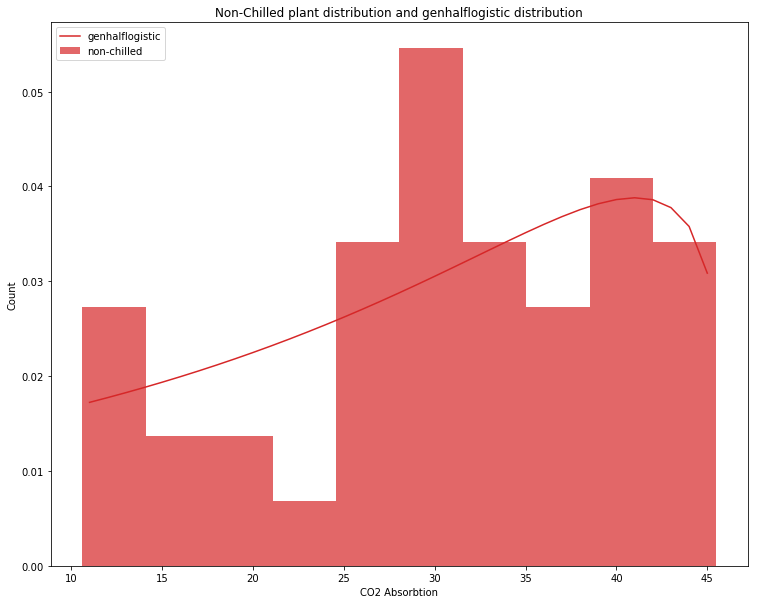

In [8]:
rvf = stats.genhalflogistic.pdf(x=[x for x in range(11,46)], c=best_shape_1[dst1][0], loc=best_shape_1[dst1][1], scale=best_shape_1[dst1][2])
plt.figure(figsize=(12.5,10))
plt.hist(nonchill_plants['uptake'], label='non-chilled', color='C3', alpha=0.7, normed=True, bins=10)
plt.plot([x for x in range(11,46)], rvf, label='genhalflogistic', color='C3')
plt.xlabel('CO2 Absorbtion')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.title('Non-Chilled plant distribution and genhalflogistic distribution')
plt.show()

It's not perfect but it looks like the genhalflogisitic distribution does indeed match our non-chilled plant data to a high degree. Both slope upward to the right and both have a little dip around 15-25 along the `CO2 Absorbtion` axis. 

We can say that if the chilled plant distribution is sufficiently different from the genhalflogistic distribution representing our non-chilled plant data that the chilled plants have had their CO2 absorbtion affected.

To measure how different the chilled plant data is from the genhalflogistic distribution we use something called a p-value. The p-value is just the probability that a certain sample of data came from a certain distribution. If we get a low enough p-value when we check to see if chilled data came from our genhalflogisitic distribution we can conclude that chilled plant data follows a different distribution and behaves differently from non-chilled data in terms of CO2 absorbtion.

To get p-value with our genhalflogisitc distribution and our chilled plant data we will feed both those into something called a Kolmogorov-Smirnov test, or [ks-test](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html). Let's calculate some p values.

In [9]:
_, nonchilled_pvalue = stats.kstest(nonchill_plants['uptake'], 'genhalflogistic', args=best_shape_1[dst1])
_, chilled_pvalue = stats.kstest(chill_plants['uptake'], 'genhalflogistic', args=best_shape_1[dst1])
print('p-value (probability) of non-chilled data being from our genhalflogistic: ', nonchilled_pvalue)
print('p-value (probability) of chilled data being from our genhalflogistic: ', chilled_pvalue)

p-value (probability) of non-chilled data being from our genhalflogistic:  0.639477797842
p-value (probability) of chilled data being from our genhalflogistic:  2.24809405358e-05


The probability that the non-chilled data is from this genhalflogistic distribution is 63.94% (p-value 0.6394). This makes sense as the genhalflogisitic distribution was craeted using this data and shaped around it. 

The **probability that the chilled plant data came from our genhalflogistic distribution is small: .00224%** (p-value 0.0000224). Usually if a p-value is lower than 0.05 you can say the p-value is 'small enough.' The statistics lingo for when we get a 'small enough' p-value is that the result we have observed is 'statistically significant.' The low probability that our  chilled data came from the same distribution as our non-chilled data **suggests that when the plants are chilled their distribution of CO2 absorbtion changes significantly.** We can verify this quickly by using fitter again and seeing what distribution our chilled plant data follows.

**Notes on p-value:**

What threshold to pick for your p-value is largely arbitrary, usually people accept 0.05 or lower, nowadays with increasing amounts of data it's getting easier to get a p-value of 0.05 and some people prefer to set the threshold lower at 0.01 or lower. [Here is a comic](https://imgs.xkcd.com/comics/p_values.png) that was meant as a joke but actually offers some insight into interpreting p-values.

In [10]:
f = Fitter(chill_plants['uptake'], bins=10)
f.verbose = False
f.fit()
best_shape_2 = f.get_best()
dst2 = list(best_shape_2.keys())[0]
print('chilled plant co2 absorbtion')
print('dstribution: {}'.format(dst2))
print('best distribution shape: {}'.format(best_shape_2[dst2]))
print('best 5 distributions, lowest 5 errors:')
f.df_errors.sort(columns=['sumsquare_error'], ascending=True).ix[:5]

chilled plant co2 absorbtion
dstribution: dweibull
best distribution shape: (2.6804403695668575, 25.999783783267702, 11.415991122238617)
best 5 distributions, lowest 5 errors:


,sumsquare_error
dweibull,0.000780
bradford,0.001794
gausshyper,0.001801
johnsonsb,0.001816
truncexpon,0.001875


It looks like the best fit for the chilled plant data is in fact a [double weibull distribution](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.stats.dweibull.html#scipy.stats.dweibull) with error value of 0.000780. This distribution looks quite different from our genhalflogistic reprsenting the non-chilled plant data. We will graph the double weibull and the chilled palnt data below. You can compare it to the graph above to see the difference.

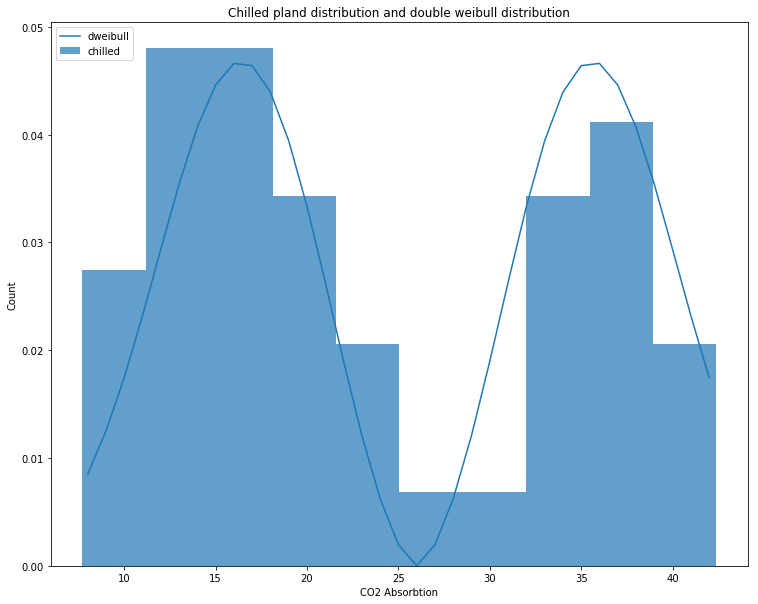

In [11]:
rvf_dwe = stats.dweibull.pdf(x=[x for x in range(8,43)],
                             c=best_shape_2[dst2][0], 
                             loc=best_shape_2[dst2][1], 
                             scale=best_shape_2[dst2][2])
plt.figure(figsize=(12.5,10))
plt.hist(chill_plants['uptake'], label='chilled', color='C0', alpha=0.7, normed=True, bins=10)
plt.plot([x for x in range(8,43)], rvf_dwe, label='dweibull', color='C0')
plt.xlabel('CO2 Absorbtion')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.title('Chilled pland distribution and double weibull distribution')
plt.show()

# Conclusion

Given the low p-value we found testing chilled plant data against the genhalflogistic distrbution we can reject our null hypothesis and accept our alternate hypothesis:

~~*Null Hypothesis*: Chilling plants does not affect their CO2 absorbtion.~~

***Alternate Hypothesis*: Chilling plants does affect their CO2 absorbtion.**

We also further confirmed that the chilled plant data follows a very different distribution than the non-chilled data. Further confirming our hypothesis that **chilling plants does affect their CO2 absorbtion.**

In this writeup you should have learned the basic underlying concept behind a hypothesis test and how we can use it to answer questions. Further you should have learned how to fit a distribution to your baseline data and then perform a statistical test on your alternate data to see if the difference between the two distributions is statistically significant.

I simplified some parts of this writeup and you may find ways to poke holes through it. I love when people do this; the best way to enjoy a writeup is often to deconstruct it.

## If you'd like to get the next blog post you can [signup here](https://yvanscher.wufoo.com/forms/z189vjhh1g7pmk0/).